In [1]:
import os 

os.chdir("app/")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.trainer import Trainer

from ptls.preprocessing import PandasDataPreprocessor
from ptls.nn import TrxEncoder
from ptls.frames import PtlsDataModule
    
from nn.seq_encoder import ConvSeqEncoder
from modules.ts2vec_module import TS2Vec
from datasets import TS2VecDataset
from utils.encode import encode_data
from utils.evaluation import bootstrap_eval

In [3]:
df = pd.read_parquet("data/preprocessed_new/churn.parquet")
df.head()

,user_id,mcc_code,timestamp,amount,global_target,holiday_target,weekend_target,churn_target,minute,hour,day,month,day_of_week,time_delta
0,0,2,2017-10-12 12:24:07,20000.0,0,0,0,0,24,12,12,10,3,0
1,0,19,2017-10-21 00:00:00,5023.0,0,0,1,0,0,0,21,10,5,732953
2,0,1,2017-10-21 00:00:00,2031.0,0,0,1,0,0,0,21,10,5,0
3,0,9,2017-10-24 13:14:24,36562.0,0,0,0,0,14,13,24,10,1,306864
4,0,10,2017-12-05 00:00:00,767.0,0,0,0,0,0,0,5,12,1,3581136


In [4]:
df[df["user_id"] == df["user_id"].unique()[5]]#["time_delta"].describe()

,user_id,mcc_code,timestamp,amount,global_target,holiday_target,weekend_target,churn_target,minute,hour,day,month,day_of_week,time_delta
753,11,10,2017-06-23,643.9,0,0,0,0,0,0,23,6,4,0
754,11,118,2017-06-23,500.0,0,0,0,0,0,0,23,6,4,0
755,11,1,2017-06-23,2993.0,0,0,0,0,0,0,23,6,4,0
756,11,8,2017-06-23,502.0,0,0,0,0,0,0,23,6,4,0
757,11,118,2017-06-23,1400.0,0,0,0,0,0,0,23,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,11,16,2017-09-10,1590.0,0,0,1,0,0,0,10,9,6,172800
966,11,10,2017-09-15,39.9,0,0,0,0,0,0,15,9,4,432000
967,11,84,2017-09-17,104.0,0,0,1,0,0,0,17,9,6,172800
968,11,4,2017-09-22,160.0,0,0,0,0,0,0,22,9,4,432000


<Axes: >

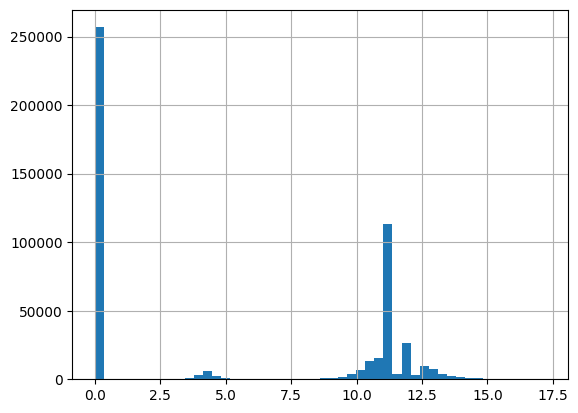

In [5]:
np.log(1 + df[(df["time_delta"] >= 0)]["time_delta"]).hist(bins=50)#.mean() / (3600*24)

In [6]:
(df[(df["time_delta"] >= 0)]["time_delta"] / (3600*24)).describe()
# df[(df["time_delta"] >= 0)]

count    490479.000000
mean          0.816425
std           2.818098
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         351.349317
Name: time_delta, dtype: float64

In [7]:
preprocessor = PandasDataPreprocessor(
    col_id="user_id",
    col_event_time="timestamp",
    event_time_transformation="dt_to_timestamp",
    cols_category=["mcc_code"],
    cols_first_item=["global_target"]
)

In [8]:
data = preprocessor.fit_transform(df[(df["time_delta"] >= 0)])

In [9]:
val_size = 0.1
test_size = 0.1

train, val_test = train_test_split(data, test_size=test_size+val_size, random_state=42)
val, test = train_test_split(val_test, test_size=test_size/(test_size+val_size), random_state=42)

In [10]:
train_ds = TS2VecDataset(train, min_seq_len=15)
val_ds = TS2VecDataset(val, min_seq_len=15)
test_ds = TS2VecDataset(test, min_seq_len=15)

In [11]:
datamodule = PtlsDataModule(
    train_data=train_ds,
    valid_data=val_ds,
    train_batch_size=128,
    valid_batch_size=128,
    train_num_workers=8,
    valid_num_workers=8
)

In [12]:
trx_encoder = TrxEncoder(
    embeddings={
        "mcc_code": {"in": 345, "out": 24}
    },
    numeric_values={
        "amount": "identity"
    },
    use_batch_norm_with_lens=True,
    norm_embeddings=False,
    embeddings_noise=0.0003
)

seq_encoder = ConvSeqEncoder(
    trx_encoder,
    hidden_size=320,
    num_layers=10,
    dropout=0.1,
)

In [13]:
from ptls.data_load.padded_batch import PaddedBatch
from ptls.nn import TrxEncoder
from ptls.data_load import PaddedBatch


class TimeTrxEncoder(TrxEncoder):
    def __init__(self, col_time="event_time", **trx_encoder_params):
        super().__init__(**trx_encoder_params)

        self.col_time = col_time

    def forward(self, x: PaddedBatch):
        embeddings = super().forward(x).payload
        timestamps = (x.payload[self.col_time] - 1444734866) / (60*60*24) * x.seq_len_mask
        return PaddedBatch({"embeddings": embeddings, self.col_time: timestamps}, x.seq_lens)

In [14]:
trx_encoder = TimeTrxEncoder(
    col_time="event_time",
    embeddings={
        "mcc_code": {"in": 345, "out": 24}
    },
    numeric_values={
        "amount": "identity"
    },
    use_batch_norm_with_lens=True,
    norm_embeddings=False,
    embeddings_noise=0.0003
)

out = trx_encoder(next(iter(datamodule.train_dataloader()))[0])



In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def hierarchical_contrastive_loss_weighted(z1, z2, t, h=1, alpha=0.5, temporal_unit=0):
    B, T = z1.size(0), z1.size(1)
    
    loss = torch.tensor(0., device=z1.device)
    d = 0
    while z1.size(1) > 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        if d >= temporal_unit:
            if 1 - alpha != 0:
                loss += (1 - alpha) * temporal_contrastive_loss(z1, z2)
        d += 1

        if t.size(1) % 2 != 0:
            t = t[:, :-1]

        delta = torch.clip(t.reshape(B, -1, 2)[:, :, 1] - t.reshape(B, -1, 2)[:, :, 0], min=0)
                
        t = t.reshape(B, -1, 2).float().mean(dim=2).reshape(B, -1)

        weights = torch.exp(-delta / (h*d)).unsqueeze(2)

        z1 = F.max_pool1d(z1.transpose(1, 2), kernel_size=2).transpose(1, 2) * weights
        z2 = F.max_pool1d(z2.transpose(1, 2), kernel_size=2).transpose(1, 2) * weights

    if z1.size(1) == 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        d += 1
    return loss / d

def instance_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if B == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=0)  # 2B x T x C
    z = z.transpose(0, 1)  # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)
    
    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    return loss

def temporal_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if T == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=1)  # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)
    
    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    return loss


class HierarchicalWeightedContrastiveLoss(nn.Module):
    def __init__(self, h=10000, alpha=0.5, temporal_unit=0):
        super().__init__()

        self.h = h
        self.alpha = alpha
        self.temporal_unit = temporal_unit

    def forward(self, embeddings, _):
        out1, out2, t1, t2 = embeddings
        return hierarchical_contrastive_loss_weighted(out1, out2, t1, t2, self.h, self.alpha, self.temporal_unit)
    

In [21]:
import torch
import numpy as np

from ptls.frames.abs_module import ABSModule
from ptls.data_load.padded_batch import PaddedBatch
from ptls.nn.head import Head

from torchmetrics import MeanMetric
from losses.hierarchical_contrastive_loss import HierarchicalContrastiveLoss


def generate_continuous_mask(B, T, n=5, l=0.1):
    res = torch.full((B, T), True, dtype=torch.bool)
    if isinstance(n, float):
        n = int(n * T)
    n = max(min(n, T // 2), 1)
    
    if isinstance(l, float):
        l = int(l * T)
    l = max(l, 1)
    
    for i in range(B):
        for _ in range(n):
            t = np.random.randint(T-l+1)
            res[i, t:t+l] = False
    return res


def generate_binomial_mask(B, T, p=0.5):
    return torch.from_numpy(np.random.binomial(1, p, size=(B, T))).to(torch.bool)


def take_per_row(A, indx, num_elem):
    all_indx = indx[:,None] + np.arange(num_elem)
    return A[torch.arange(all_indx.shape[0])[:,None], all_indx]


def mask_input(x, mask):
    shape = x.size()

    if mask == 'binomial':
        mask = generate_binomial_mask(shape[0], shape[1]).to(x.device)
    elif mask == 'continuous':
        mask = generate_continuous_mask(shape[0], shape[1]).to(x.device)
    elif mask == 'all_true':
        mask = x.payload.new_full((shape[0], shape[1]), True, dtype=torch.bool)
    elif mask == 'all_false':
        mask = x.payload.new_full((shape[0], shape[1]), False, dtype=torch.bool)
    elif mask == 'mask_last':
        mask = x.payload.new_full((shape[0], shape[1]), True, dtype=torch.bool)
        mask[:, -1] = False

    x[~mask] = 0

    return x


class TS2Vec(ABSModule):
    '''The TS2Vec model'''
    
    def __init__(
        self,
        seq_encoder,
        mask_mode="binomial",
        head=None,
        loss=None,
        validation_metric=None,
        optimizer_partial=None,
        lr_scheduler_partial=None
    ):
        ''' Initialize a TS2Vec model.
        
        Args:
        '''
        if head is None:
            head = Head(use_norm_encoder=True)
        
        if loss is None:
            loss = HierarchicalContrastiveLoss(alpha=0.5, temporal_unit=0)

        self.temporal_unit = loss.temporal_unit
        self.mask_mode = mask_mode
        
        super().__init__(validation_metric,
                         seq_encoder,
                         loss,
                         optimizer_partial,
                         lr_scheduler_partial)

        self._head = head
        self.valid_loss = MeanMetric()

    def shared_step(self, x, y):
        trx_encoder = self._seq_encoder.trx_encoder
        seq_encoder = self._seq_encoder.seq_encoder 

        seq_lens = x.seq_lens
        encoder_out = trx_encoder(x).payload

        x = encoder_out["embeddings"]
        t = encoder_out["event_time"]

        ts_l = x.size(1)
        crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
        crop_left = np.random.randint(ts_l - crop_l + 1)
        crop_right = crop_left + crop_l
        crop_eleft = np.random.randint(crop_left + 1)
        crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
        crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))

        input1 = take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft)
        input2 = take_per_row(x, crop_offset + crop_left, crop_eright - crop_left)
        
        t1 = take_per_row(t, crop_offset + crop_eleft, crop_right - crop_eleft)
        t2 = take_per_row(t, crop_offset + crop_left, crop_eright - crop_left)
        
        input1_masked = mask_input(input1, self.mask_mode)
        input2_masked = mask_input(input2, self.mask_mode)
        
        out1 = seq_encoder(PaddedBatch(input1_masked, seq_lens)).payload
        out1 = out1[:, -crop_l:]

        out2 = seq_encoder(PaddedBatch(input2_masked, seq_lens)).payload
        out2 = out2[:, :crop_l]
        
        t1 = t1[:, -crop_l:]
        t2 = t2[:, :crop_l]
        
        if self._head is not None:
            out1 = self._head(out1)
            out2 = self._head(out2)

        return (out1, out2, t1, t2), y

    def validation_step(self, batch, _):
        y_h, y = self.shared_step(*batch)
        loss = self._loss(y_h, y)
        self.valid_loss(loss)

    def validation_epoch_end(self, outputs):
        self.log(f'valid_loss', self.valid_loss, prog_bar=True)
        # self._validation_metric.reset()

    @property
    def is_requires_reduced_sequence(self):
        return False
    
    @property
    def metric_name(self):
        return "valid_loss"

In [22]:
trx_encoder = TimeTrxEncoder(
    col_time="event_time",
    embeddings={
        "mcc_code": {"in": 345, "out": 24}
    },
    numeric_values={
        "amount": "identity"
    },
    use_batch_norm_with_lens=True,
    norm_embeddings=False,
    embeddings_noise=0.0003
)

seq_encoder = ConvSeqEncoder(
    trx_encoder,
    hidden_size=1024,
    num_layers=10,
    dropout=0.1,
)

In [23]:
lr_scheduler_partial = partial(torch.optim.lr_scheduler.ReduceLROnPlateau, factor=.9025, patience=5, mode="min")
optimizer_partial = partial(torch.optim.Adam, lr=4e-3)

model = TS2Vec(
    seq_encoder,
    loss=HierarchicalWeightedContrastiveLoss(h=0.1),
    optimizer_partial=optimizer_partial,
    lr_scheduler_partial=lr_scheduler_partial
)

In [24]:
checkpoint = ModelCheckpoint(
    monitor="valid_loss", 
    mode="min"
)

trainer = Trainer(
    max_epochs=30,
    devices=[0],
    accelerator="gpu",
    callbacks=[checkpoint]
)

trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type                                | Params
---------------------------------------------------------------------
0 | _loss        | HierarchicalWeightedContrastiveLoss | 0     
1 | _seq_encoder | ConvSeqEncoder                      | 3.3 M 
2 | _head        | Head                                | 0     
3 | valid_loss   | MeanMetric                          | 0     
---------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.190    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

True
tensor([[[1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        [[1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        [[1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        ...,

        [[4.5400e-05],
         [1.0000e+00],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        [[2.0612e-09],
         [2.1645e-03],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        [[1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         ...,
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]]], device='cuda:0')
True
tensor([[[1.0000e+00],
         [1.

/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

True
tensor([[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]], device='cuda:0')
True
tensor([[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

     

/home/macro-micro-coles/miniconda/envs/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [32]:
model.load_state_dict(torch.load(checkpoint.best_model_path)["state_dict"])

<All keys matched successfully>

In [66]:
np.linspace(0.2, 20, 100)

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8,
       20. ])

In [55]:
train_val_ds = TS2VecDataset(train + val, min_seq_len=15)

In [56]:
X_train, y_train = encode_data(model.seq_encoder, train_val_ds)
X_test, y_test = encode_data(model.seq_encoder, test_ds)

print("Train size:", len(y_train))
print("Test size:", len(y_test))

Train size: 3958
Test size: 446


In [57]:
results = bootstrap_eval(X_train, X_test, y_train, y_test, n_runs=10)

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


In [58]:
results

,ROC-AUC,PR-AUC,Accuracy
0,0.604812,0.689422,0.616592
1,0.634907,0.692621,0.641256
2,0.609411,0.681205,0.618834
3,0.611555,0.677632,0.616592
4,0.601461,0.689708,0.609865
5,0.629017,0.687650,0.639013
6,0.624105,0.672256,0.643498
7,0.609744,0.672002,0.630045
8,0.617507,0.682428,0.612108
9,0.633325,0.683475,0.643498


In [60]:
results.agg(["mean", "std"])

,ROC-AUC,PR-AUC,Accuracy
mean,0.617584,0.68284,0.627130
std,0.012059,0.00722,0.013743


In [3]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt

In [14]:
def get_df(files, key):

    h_list = []
    results = []
    
    for f in files:
        h = float(f.split("=")[-1].replace(".csv", ""))
        h_list.append(h)
        df = pd.read_csv(f)
        
        results.append(df[key].agg(["mean", "std"]))
    
    return pd.DataFrame(results, index=h_list).sort_index()


def plot_df(df_roc, df_pr):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(df_roc["mean"], color="#98DB2C", linewidth=3)
    axes[1].plot(df_pr["mean"], color="#98DB2C", linewidth=3)
    # plt.plot(df["mean"] + 1.96*df["std"]/np.sqrt(10), color="red", linestyle="--")
    # plt.plot(df["mean"] - 1.96*df["std"]/np.sqrt(10), color="red", linestyle="--")

    axes[0].set_xlabel("h")
    axes[0].set_ylabel("ROC-AUC")
    axes[1].set_xlabel("h")
    axes[1].set_ylabel("PR-AUC")

In [18]:
files = glob.glob("experiments_h_results/new/*.csv")

res_roc_sqrt = get_df(files, "ROC-AUC")
res_pr_sqrt = get_df(files, "PR-AUC")

# plot_df(res_roc, res_pr)

In [19]:
# churn without sqrt
files = glob.glob("experiments_h_results/sqrt/*.csv")

res_roc = get_df(files, "ROC-AUC")
res_pr = get_df(files, "PR-AUC")

# plot_df(res_roc, res_pr)

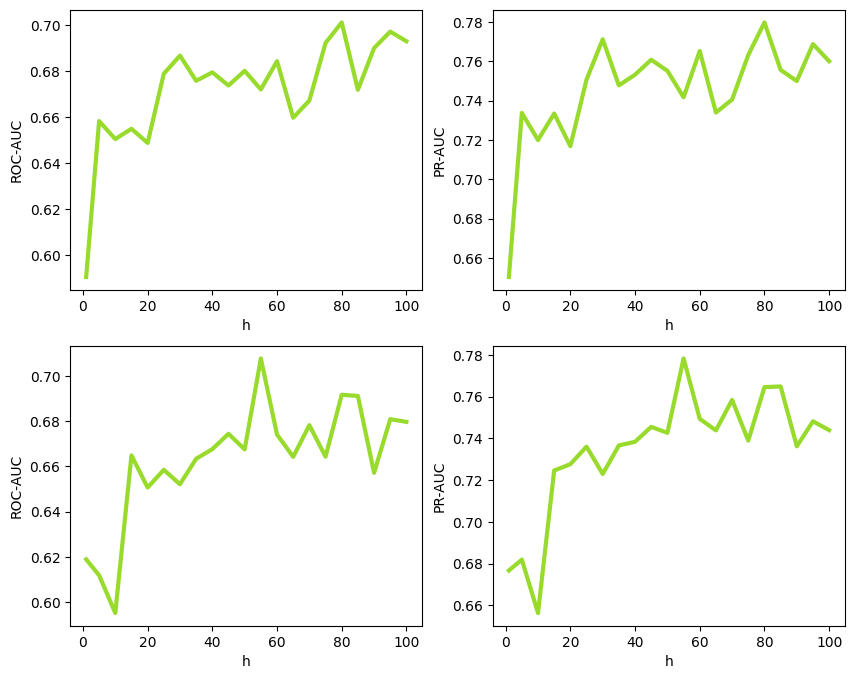

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for df, ax, m in zip([res_roc_sqrt, res_pr_sqrt, res_roc, res_pr], 
                  axes.flatten(),
                  ["ROC-AUC", "PR-AUC", "ROC-AUC", "PR-AUC",]):
    ax.plot(df["mean"], color="#98DB2C", linewidth=3)
    ax.set_xlabel("h")
    ax.set_ylabel(m)

In [32]:
files = glob.glob("experiments_h_results/new_default/*.csv")

res_roc_sqrt = get_df(files, "ROC-AUC")
res_pr_sqrt = get_df(files, "PR-AUC")

# churn without sqrt
files = glob.glob("experiments_h_results/sqrt_default/*.csv")

res_roc = get_df(files, "ROC-AUC")
res_pr = get_df(files, "PR-AUC")

# plot_df(res_roc, res_pr)

In [34]:
res_roc

,mean,std
0.10,0.577380,0.027840
0.20,0.590520,0.027701
0.25,0.556970,0.036973
0.50,0.590565,0.029363
0.80,0.571131,0.035387
1.00,0.576088,0.027621
2.00,0.619287,0.036156
5.00,0.586945,0.021270
10.00,0.576297,0.018892
15.00,0.572896,0.036677


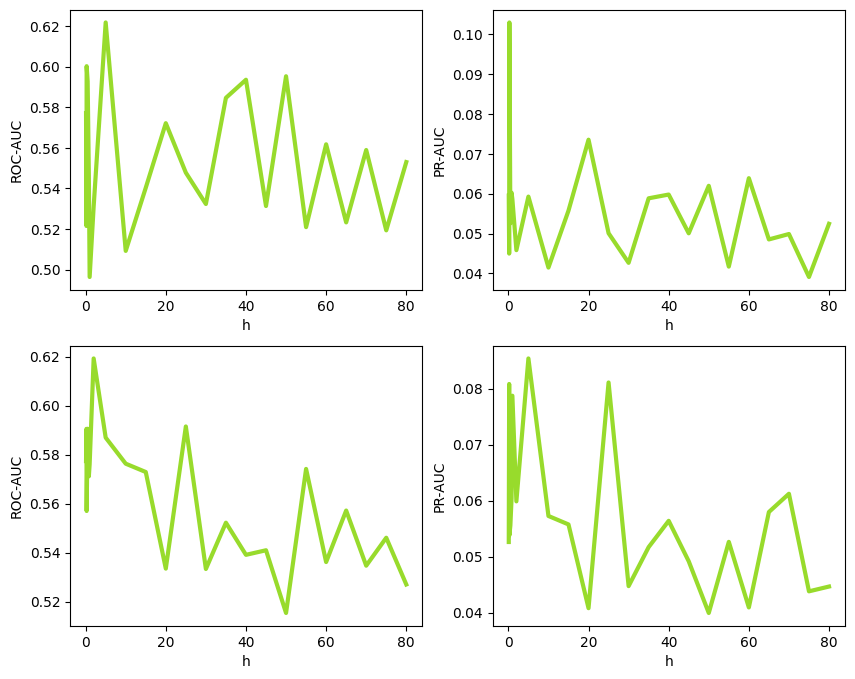

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for df, ax, m in zip([res_roc_sqrt, res_pr_sqrt, res_roc, res_pr], 
                  axes.flatten(),
                  ["ROC-AUC", "PR-AUC", "ROC-AUC", "PR-AUC",]):
    ax.plot(df["mean"], color="#98DB2C", linewidth=3)
    ax.set_xlabel("h")
    ax.set_ylabel(m)

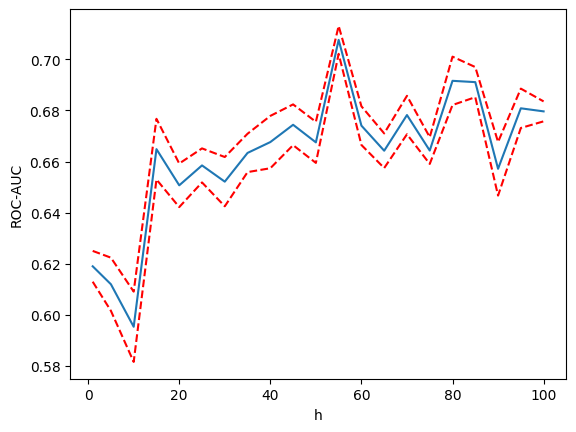

In [5]:
# churn with sqrt
files = glob.glob("experiments_h_results/sqrt/*.csv")

res = get_df(files)
plot_df(res)

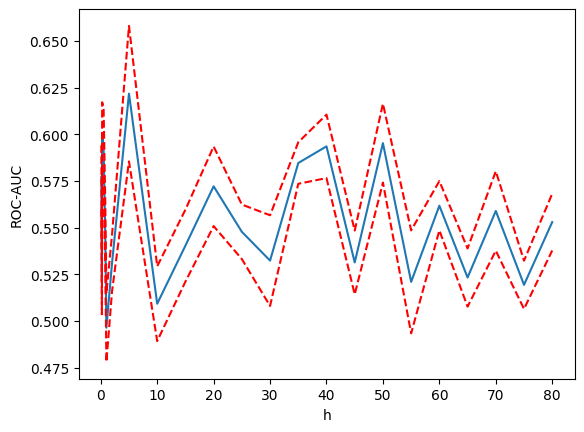

In [6]:
# defalut without sqrt
files = glob.glob("experiments_h_results/new_default/*.csv")

res = get_df(files)
plot_df(res)

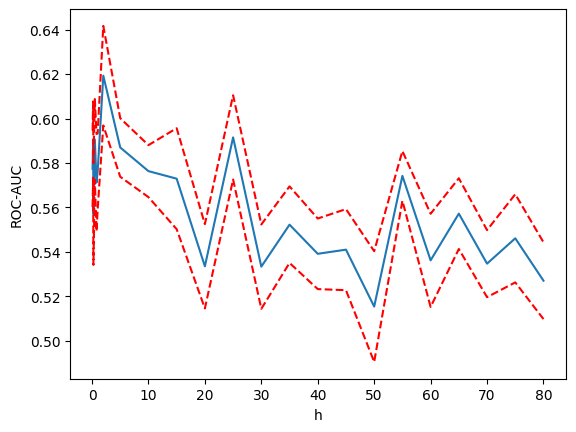

In [7]:
# defalut with sqrt
files = glob.glob("experiments_h_results/sqrt_default/*.csv")

res = get_df(files)
plot_df(res)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

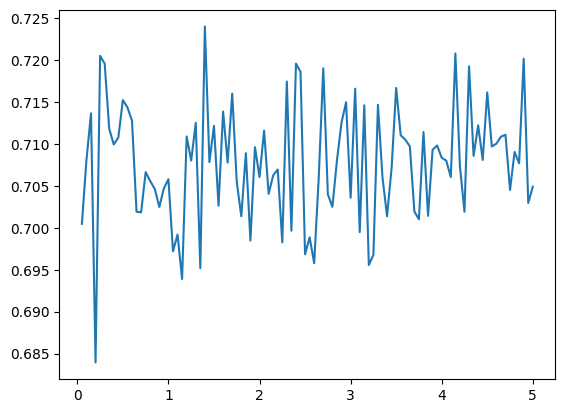

In [6]:
df = pd.read_csv("new_results/churn/identity.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
# plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
# plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))

,h,ROC-AUC_mean,ROC-AUC_std,PR-AUC_mean,PR-AUC_std
0,0.01,0.700025,0.015572,0.765640,0.013069
1,0.05,0.710987,0.013731,0.776075,0.014315
2,0.10,0.695806,0.032341,0.759455,0.035619
3,0.20,0.710682,0.016134,0.781667,0.014228
4,0.25,0.704600,0.006551,0.774329,0.002446
5,0.30,0.707707,0.018761,0.777838,0.019370
6,0.50,0.708795,0.008965,0.777522,0.017180
7,0.75,0.705870,0.017658,0.777174,0.023087
8,1.00,0.714898,0.018684,0.792450,0.015815
9,3.00,0.705392,0.020613,0.779286,0.010734


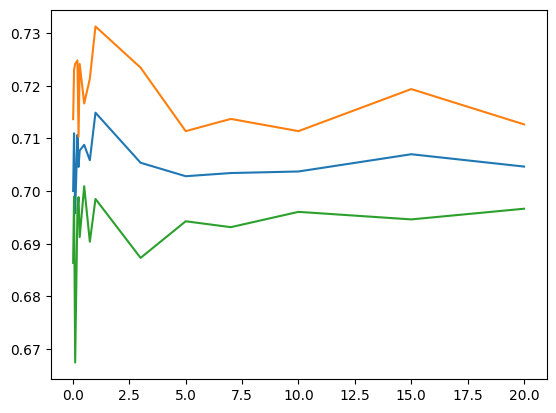

In [7]:
df = pd.read_csv("new_results copy/churn/identity.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))
df

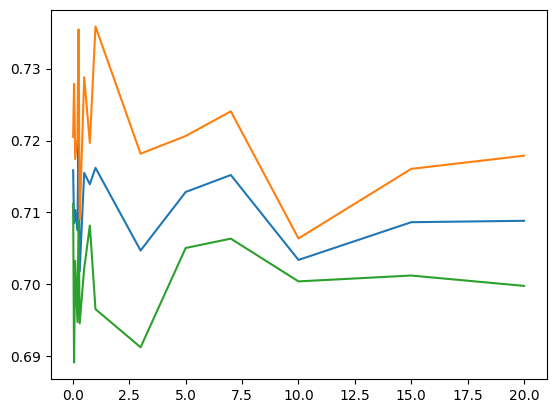

In [27]:
df = pd.read_csv("new_results/churn/sqrt.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))

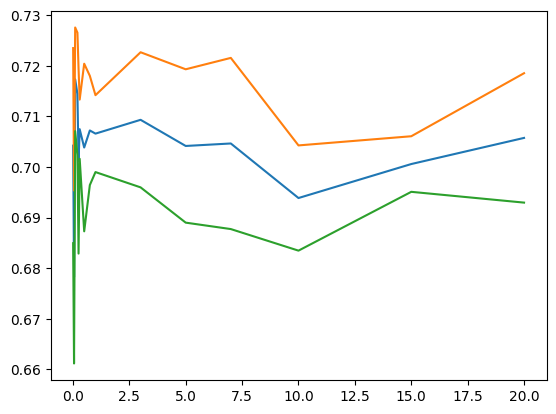

In [38]:
df = pd.read_csv("new_results/churn/pow.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))

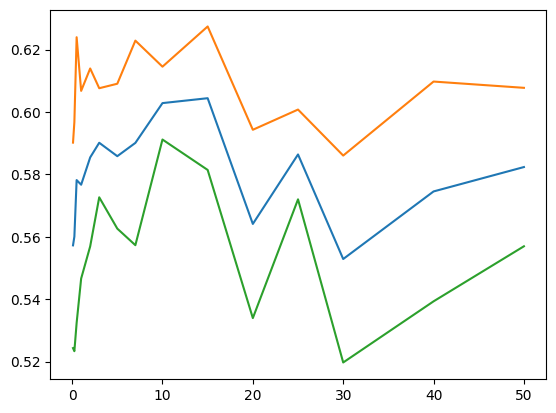

In [34]:
df = pd.read_csv("new_results/default/identity.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))

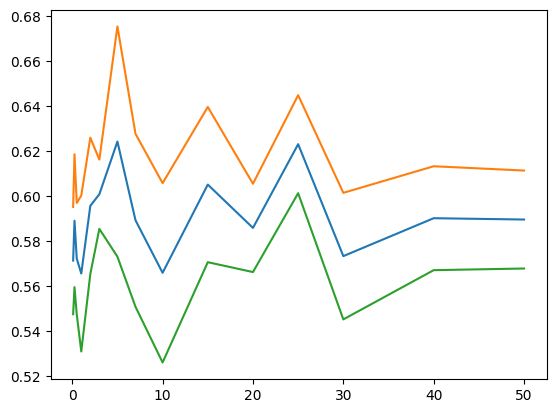

In [35]:
df = pd.read_csv("new_results/default/sqrt.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))

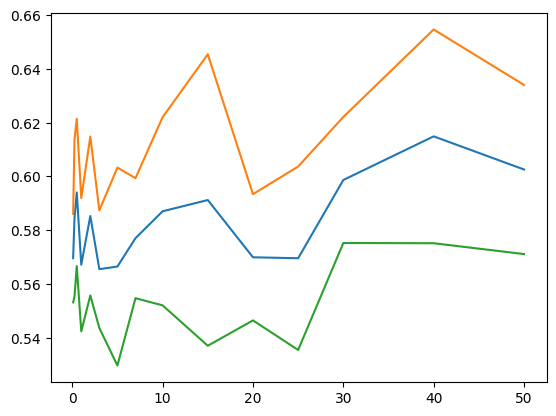

In [39]:
df = pd.read_csv("new_results/default/pow.csv")

plt.plot(df["h"], df["ROC-AUC_mean"])
plt.plot(df["h"], df["ROC-AUC_mean"] + 1.96*df["ROC-AUC_std"]/np.sqrt(5))
plt.plot(df["h"], df["ROC-AUC_mean"] - 1.96*df["ROC-AUC_std"]/np.sqrt(5))